# Decision Trees Classifier and Regressor

### Imports

In [1]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, r2_score

### Load and Clean Data

In [2]:
# Assuming 'df' is your DataFrame containing the data
df = pd.read_csv('../Data/dataset83.csv')
df.drop(['Year_start', 'Year_end'], axis='columns', inplace=True)

label_encoder = LabelEncoder()

df['Species'] = label_encoder.fit_transform(df['Species'])
df['Population'] = label_encoder.fit_transform(df['Population'])
df['Sex'] = label_encoder.fit_transform(df['Sex'])

# Converting a column to float
df['Thorax_length'] = pd.to_numeric(df['Thorax_length'], errors='coerce').astype('float64')

# Converting a column to int (after ensuring it's first converted to float to handle non-integer formats)
df['wing_loading'] = pd.to_numeric(df['wing_loading'], errors='coerce').astype('float64')

for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        # Fill missing values with mean for numerical columns
        col_mean = df[col].mean()
        df[col] = df[col].fillna(col_mean)
    elif df[col].dtype == 'object':
        # Fill missing values with mode for categorical columns
        col_mode = df[col].mode()[0]
        df[col] = df[col].fillna(col_mode)

### Feature selection and Normalisation/Labeling

In [3]:
X = df.drop(['wing_loading', 'Sex'], axis=1)
y_reg = df['wing_loading']
y_cls = df['Sex']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.1, random_state=420)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_scaled, y_cls, test_size=0.1, random_state=420)

### Regression Model

In [4]:
# Decision Tree for Regression
dt_regressor = DecisionTreeRegressor(random_state=420)
params_reg = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}
grid_reg = GridSearchCV(dt_regressor, params_reg, cv=10, scoring='neg_mean_squared_error', error_score='raise')
grid_reg.fit(X_train_reg, y_train_reg)

print(f"Best parameters for regression: {grid_reg.best_params_}")
print(f"Best MSE for regression: {-grid_reg.best_score_}")

y_pred_reg = grid_reg.predict(X_test_reg)
print(f"Test MSE for regression: {mean_squared_error(y_test_reg, y_pred_reg)}")

Best parameters for regression: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best MSE for regression: 0.004283389716664032
Test MSE for regression: 0.0008353483121192364


### Predictions and Residuals

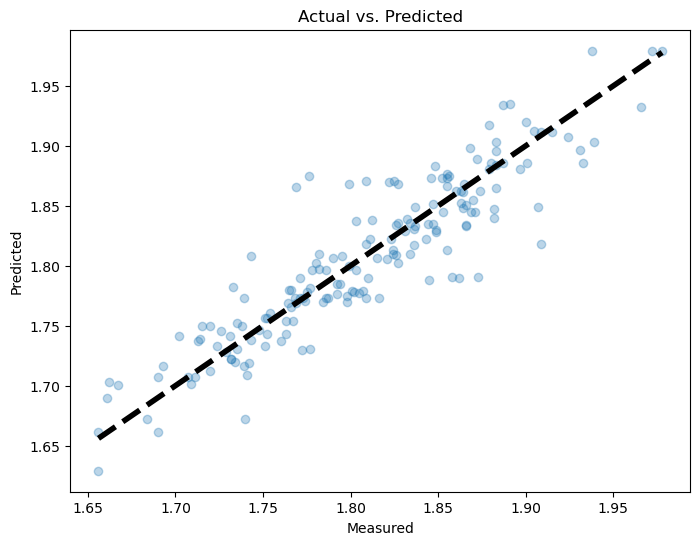

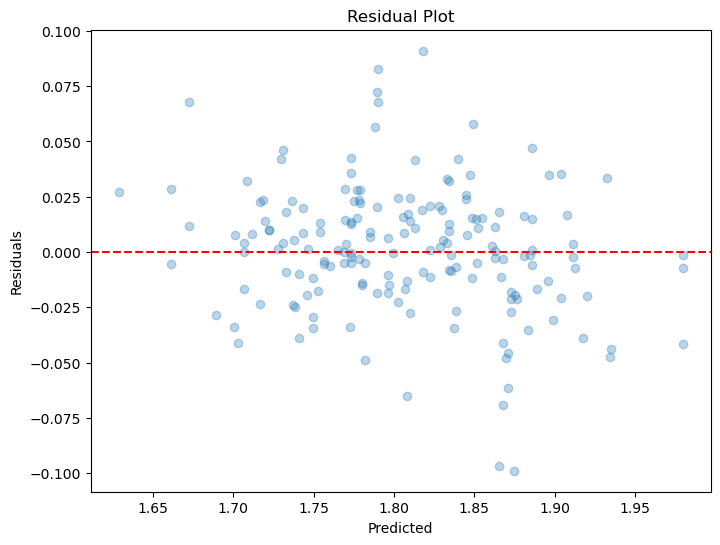

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.3)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=4)
plt.title('Actual vs. Predicted')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.show()

# Plotting residuals
residuals = y_test_reg - y_pred_reg
plt.figure(figsize=(8,6))
plt.scatter(y_pred_reg, residuals, alpha=0.3)
plt.title('Residual Plot')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

### Error and R Squared

In [6]:
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

MSE: 0.0008353483121192364
R2 Score: 0.8188373856997494


### Error Distribution

/home/adam/miniconda3/envs/datascience/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


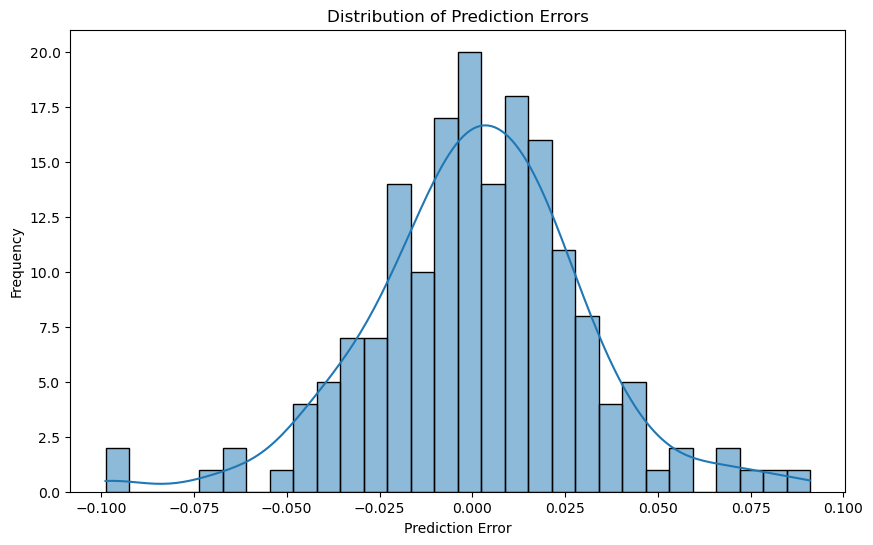

In [7]:
errors = residuals  # Which are y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

### Decision Tree Visualisation

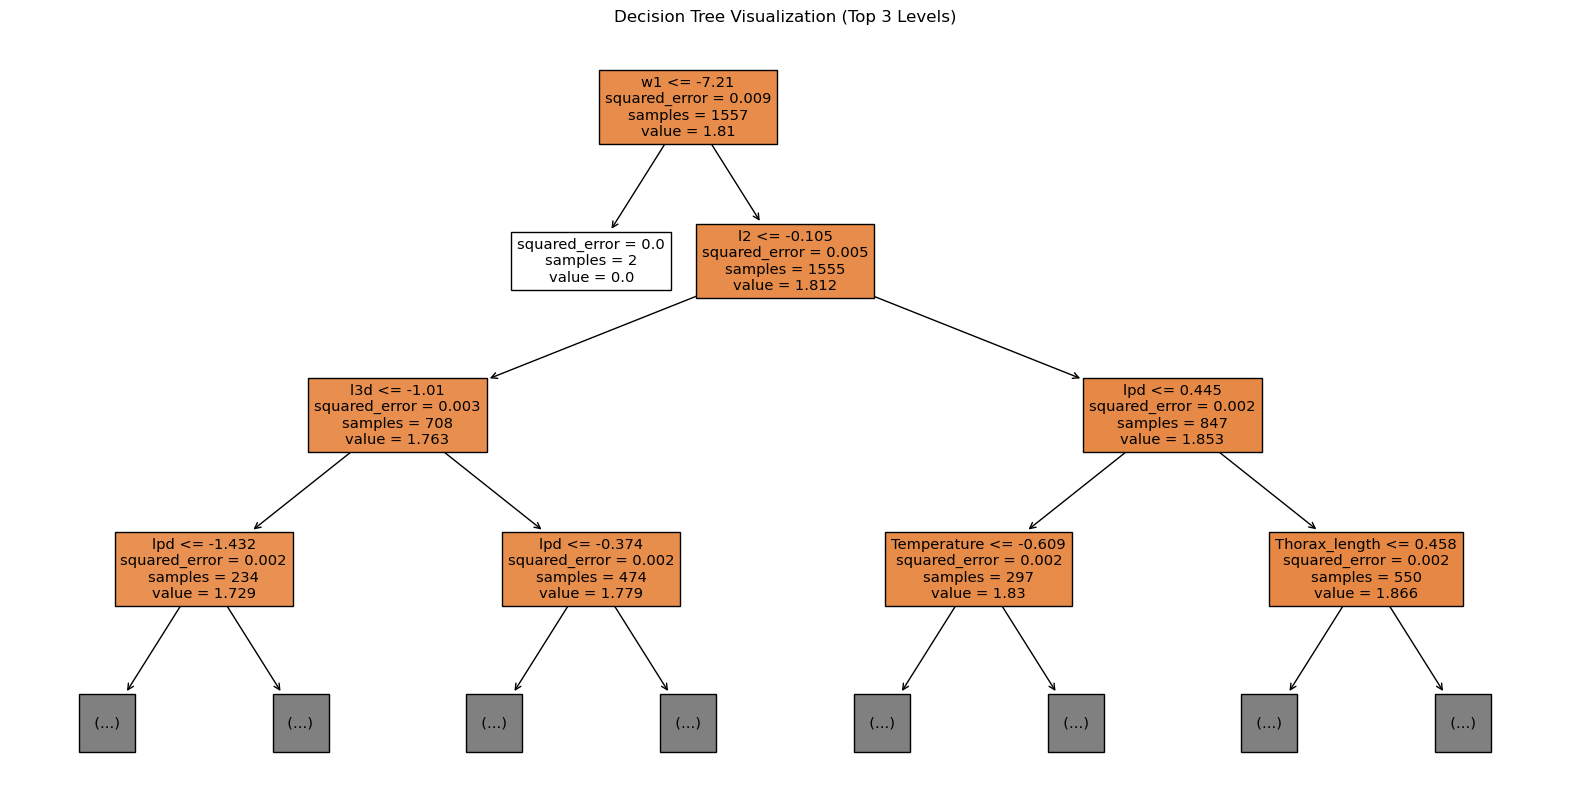

In [8]:
plt.figure(figsize=(20, 10))
plot_tree(grid_reg.best_estimator_, filled=True, feature_names=list(X.columns), max_depth=3,
          class_names=['Class0', 'Class1'])
plt.title('Decision Tree Visualization (Top 3 Levels)')
plt.show()

### Classification Model

In [9]:
# Decision Tree for Classification
dt_classifier = DecisionTreeClassifier(random_state=420)
params_cls = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}
grid_cls = GridSearchCV(dt_classifier, params_cls, cv=10, scoring='accuracy', error_score='raise')
grid_cls.fit(X_train_cls, y_train_cls)

print(f"Best parameters for classification: {grid_cls.best_params_}")
print(f"Best accuracy for classification: {grid_cls.best_score_}")

y_pred_cls = grid_cls.predict(X_test_cls)
print(f"Test accuracy for classification: {accuracy_score(y_test_cls, y_pred_cls)}")
print(classification_report(y_test_cls, y_pred_cls))

Best parameters for classification: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}
Best accuracy for classification: 0.9331968569065342
Test accuracy for classification: 0.9425287356321839
              precision    recall  f1-score   support

           0       0.99      0.90      0.94        86
           1       0.91      0.99      0.95        88

    accuracy                           0.94       174
   macro avg       0.95      0.94      0.94       174
weighted avg       0.95      0.94      0.94       174



### Confusion Matrix

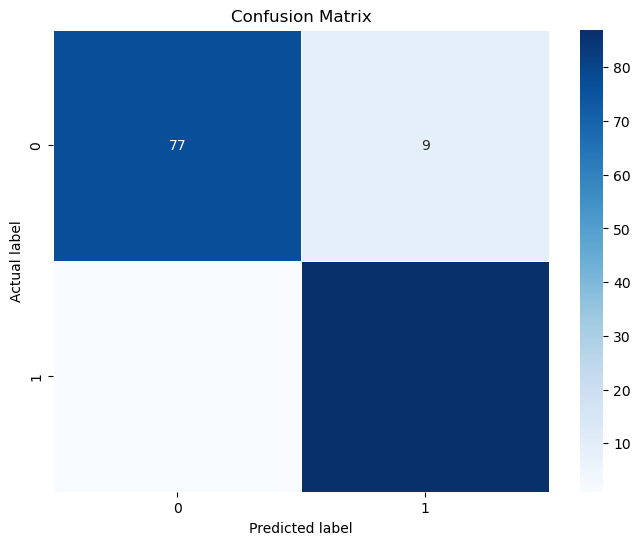

In [10]:
# Assuming y_test_cls and y_pred_cls are already defined from your classification model
cm = confusion_matrix(y_test_cls, y_pred_cls)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### Feature Importance

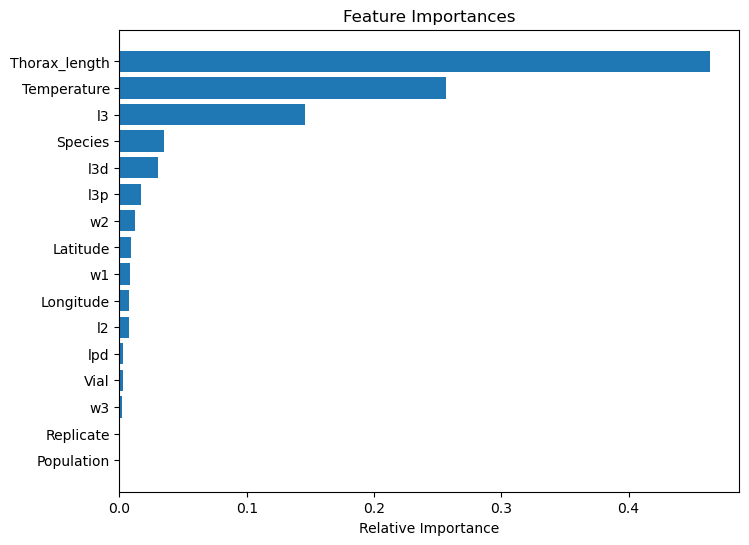

In [11]:
features = X.columns
importances = grid_cls.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Decision Tree Visualisation

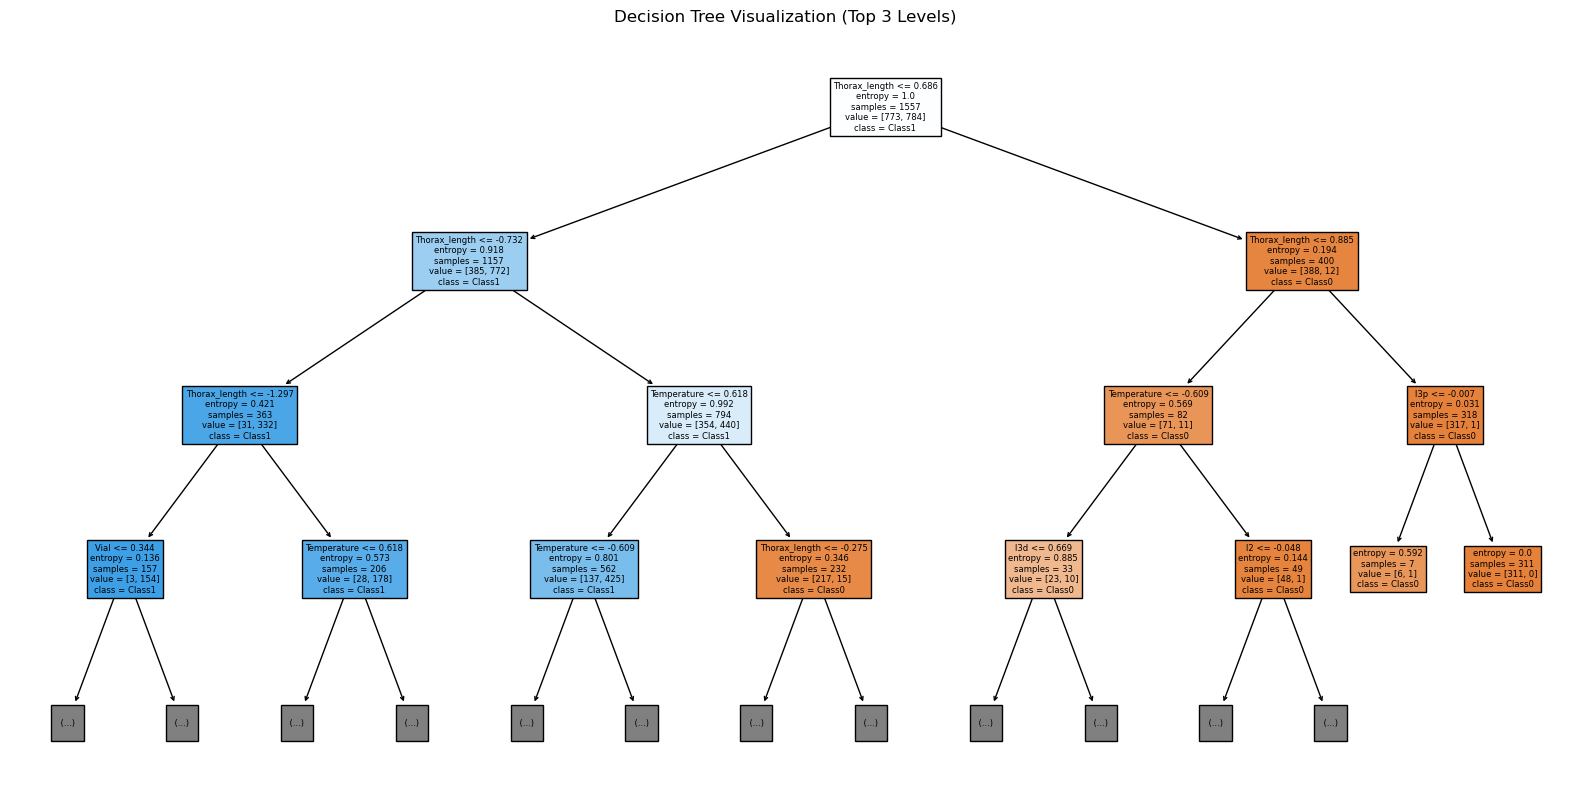

In [12]:
plt.figure(figsize=(20, 10))
plot_tree(grid_cls.best_estimator_, filled=True, feature_names=list(X.columns), max_depth=3,
          class_names=['Class0', 'Class1'])
plt.title('Decision Tree Visualization (Top 3 Levels)')
plt.show()